<h1> Práctica 2 - APCC. </h1>

<h3>Teleportación Cuántica y Codificación Superdensa.</h3>

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import(QuantumCircuit, transpile, providers, QuantumRegister, ClassicalRegister)
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

# Save an IBM Quantum account and set it as your default account.
service = QiskitRuntimeService(channel="ibm_quantum", token="")
backends = service.backends()

print("Backends disponibles: ")
for backend in backends:
    print(backend)

Backends disponibles: 
<IBMBackend('simulator_statevector')>
<IBMBackend('simulator_stabilizer')>
<IBMBackend('ibm_brisbane')>
<IBMBackend('ibm_kyoto')>
<IBMBackend('ibm_osaka')>
<IBMBackend('ibmq_qasm_simulator')>
<IBMBackend('simulator_extended_stabilizer')>
<IBMBackend('simulator_mps')>


**Ejercicio 1**. Implementar con Qiskit la teleportación cuántica, simulándolo con al menos dos simuladores locales. ¿Cómo compruebas que funciona? Mostrar y comentar resultados.

In [2]:
# Importamos todo lo necesario
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

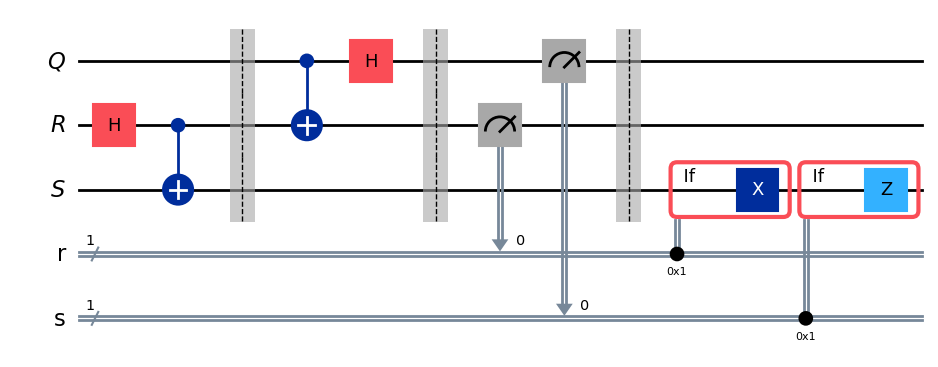

In [3]:
# Implementamos el protocolo de teleportacion cuantica

# Nombramos los qubits y los bits clasicos
qubitQ = QuantumRegister(1, "Q")
qubitR = QuantumRegister(1, "R")
qubitS = QuantumRegister(1, "S")
r = ClassicalRegister(1, "r")
s = ClassicalRegister(1, "s")

# ORDEN QUBITS: 
    # Q = Alice quiere transmitir Q a Bob. Utiliza R y S.
    # R = qubit de Alice
    # S = qubit de Bob, el destinatario de la teleportacion

teleport = QuantumCircuit(qubitQ, qubitR, qubitS, r, s)

# Alice prepara un estado entrelazado entre R y S
teleport.h(qubitR)
teleport.cx(qubitR, qubitS)
teleport.barrier()

# Alice realiza una medición de Bell sobre sus qubits Q y R
teleport.cx(qubitQ, qubitR)
teleport.h(qubitQ)
teleport.barrier()

# Realizamos mediciones y enviamos los bits clasicos a Bob por un canal clasico
teleport.measure(qubitR, r)
teleport.measure(qubitQ, s)
teleport.barrier()

# Ahora que Alice ha medido los 2 qubits, sus estados han colapsado a 0 y 1. 
# Dependiendo de los valores que reciba Bob, debe realizar una serie de operaciones sobre S.
# Si se realizan las operaciones correctas, con seguridad el qubit de Bob tiene el estado del de Alice.
with teleport.if_test((r, 1)):
    teleport.x(qubitS)
with teleport.if_test((s, 1)):
    teleport.z(qubitS)

teleport.draw('mpl')

El circuito primero inicializa R y S a |+> y después aplica el protocolo descrito tanto en los comentarios de la sección anterior como en el guión de la práctica. 

Para comprobar que el protocolo funciona correctamente, aplicaremos una puerta unitaria generada aleatoriamente al estado inicial |0> del qubit Q. Al aplicar el inverso (la conjugada transpuesta) de dicha puerta a S tras aplicar el protocolo, podemos verificar si el estado se teleportó realizando una medida y comprobando que se retorna el estado |0>.

Primero, creamos una puerta unitaria aleatoria.

In [4]:
puertaAleatoria = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi,
)

display(puertaAleatoria.to_matrix())

array([[ 0.71486503+0.j        , -0.64915404-0.25993656j],
       [ 0.51179258+0.4764833j ,  0.30464424+0.64670233j]])

Ahora, creamos el circuito anteriormente mencionado (puertaAleatoria a Q, protocolo de teleportación y puertaAleatoria conjugada transpuesta). El resultado debe ser 0.

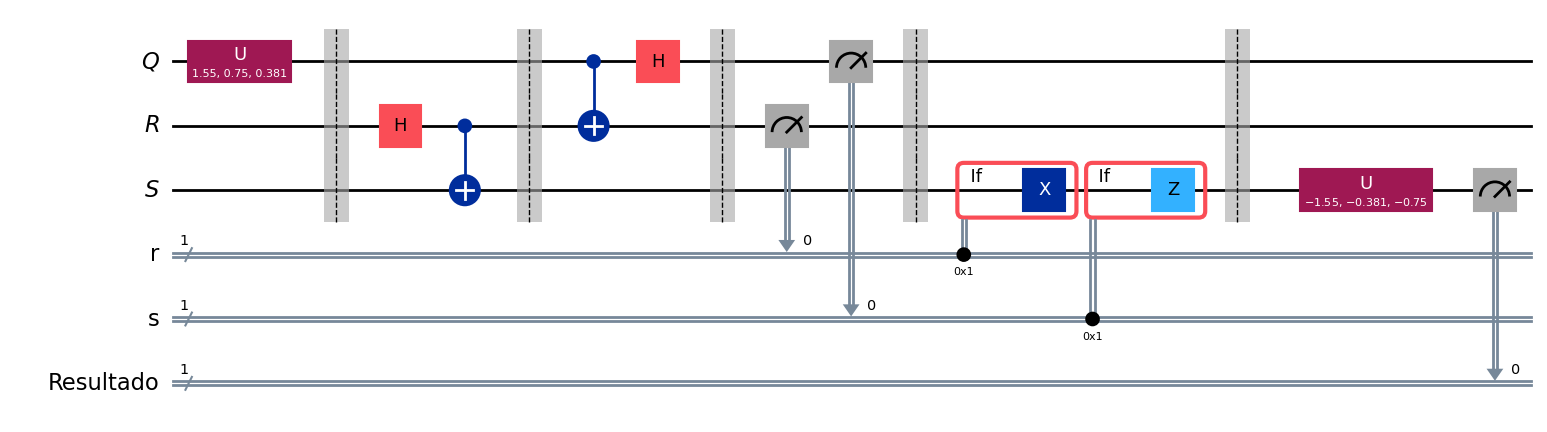

In [5]:
# Creamos un circuito nuevo que incorpore al anterior
newTeleport = QuantumCircuit(qubitQ, qubitR, qubitS, r, s)

# Aplicamos la puerta aleatoria a Q
newTeleport.append(puertaAleatoria, qubitQ)
newTeleport.barrier()

# Incorporamos el anterior circuito.
newTeleport = newTeleport.compose(teleport)
newTeleport.barrier()

# Aplicamos la inversa de la puertaAleatoria y medimos B
newTeleport.append(puertaAleatoria.inverse(), qubitS)

result = ClassicalRegister(1, "Resultado")
newTeleport.add_register(result)
newTeleport.measure(qubitS, result)

newTeleport.draw('mpl')

Por úlitmo, ejecutamos el simulador Aer y mostramos los resultados. 

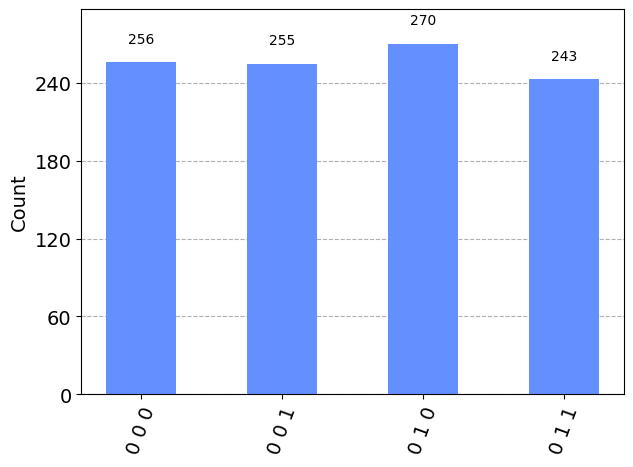

In [10]:
result = AerSimulator().run(newTeleport).result()
counts = result.get_counts()
display(plot_histogram(counts))

El diagrama muestra en primera posición, en el bit abajo a la izquierda, el valor 0, correspondiente con el estado en el que nos encontrabamos al inicio en Q. Los otros dos bits se distribuyen uniformemente. Podemos filtrar las estadísticas para ver más claramente que la teleportación ha tenido éxito, tomando únicamente el bit clásico s.

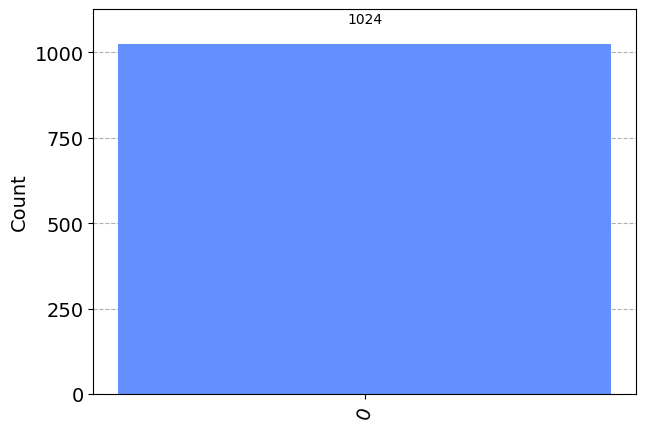

In [11]:
filtro = marginal_distribution(counts, [2])
display(plot_histogram(filtro))

Ya hemos demostrado que la teleportación, efectivamente, funciona. Sin embargo, el anterior circuito presenta el problema de que es dinámico y no es soportado por algunos simuladores como qasm. 

Para simularlo sin problemas, podemos hacer algunas modificaciones en el circuito. Considerando que al realizar una medida el estado de un qubit colapsa, podemos aprovechar el estado colpasado obtenido de dichas mediciones como los qubits de control para puertas CX y CZ. 

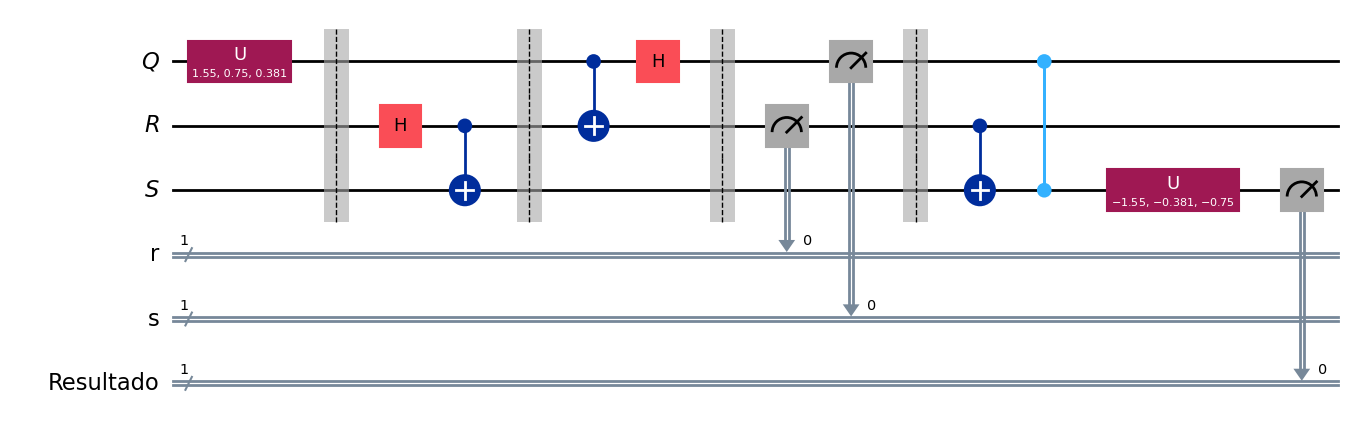

In [6]:

teleport2 = QuantumCircuit(qubitQ, qubitR, qubitS, r, s)

# Aplicamos la puerta aleatoria a Q
teleport2.append(puertaAleatoria, qubitQ)
teleport2.barrier()

# Alice prepara un estado entrelazado entre R y S
teleport2.h(qubitR)
teleport2.cx(qubitR, qubitS)
teleport2.barrier()

# Alice realiza una medición de Bell sobre sus qubits Q y R
teleport2.cx(qubitQ, qubitR)
teleport2.h(qubitQ)
teleport2.barrier()

# Realizamos mediciones y enviamos los bits clasicos a Bob por un canal clasico
teleport2.measure(qubitR, r)
teleport2.measure(qubitQ, s)
teleport2.barrier()

# Operaciones del protocolo, empleando estados colapsados (puertas CX y CZ)
teleport2.cx(1,2)
teleport2.cz(0,2)

# Aplicamos la inversa de la puertaAleatoria y medimos B
teleport2.append(puertaAleatoria.inverse(), qubitS)

# Medimos el qubit de Bob
result = ClassicalRegister(1, "Resultado")
teleport2.add_register(result)
teleport2.measure(qubitS,result) 

# Mostramos el circuito
teleport2.draw('mpl')

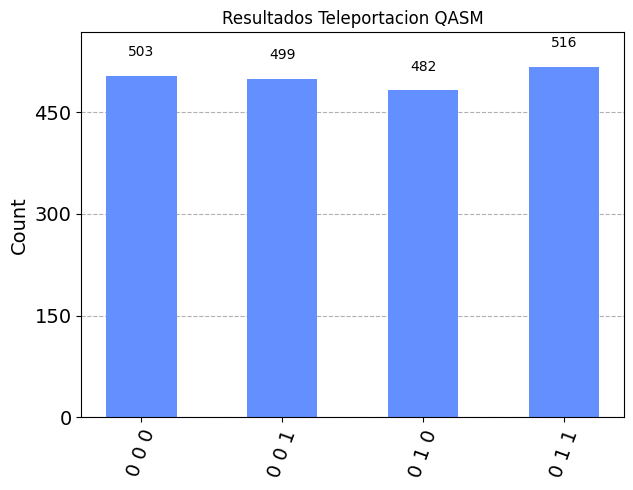

In [19]:
# Realizamos simulacion local
simulator = service.get_backend('ibmq_qasm_simulator')
qc = transpile(teleport2, simulator)
result = simulator.run(qc, shots = 2000).result()
# Mostramos resultados
plot_histogram(result.get_counts(qc), title = "Resultados Teleportacion QASM")

Al igual que en la ejecución anterior, observamos que los resultados son los esperados, pues obtenemos 0 en el último qubit. 

Análogo a estos experimentos, podemos almacenar directamente el estado inicial antes de aplicar el protocolo y compararlo con el estado final tras aplicarlo. 

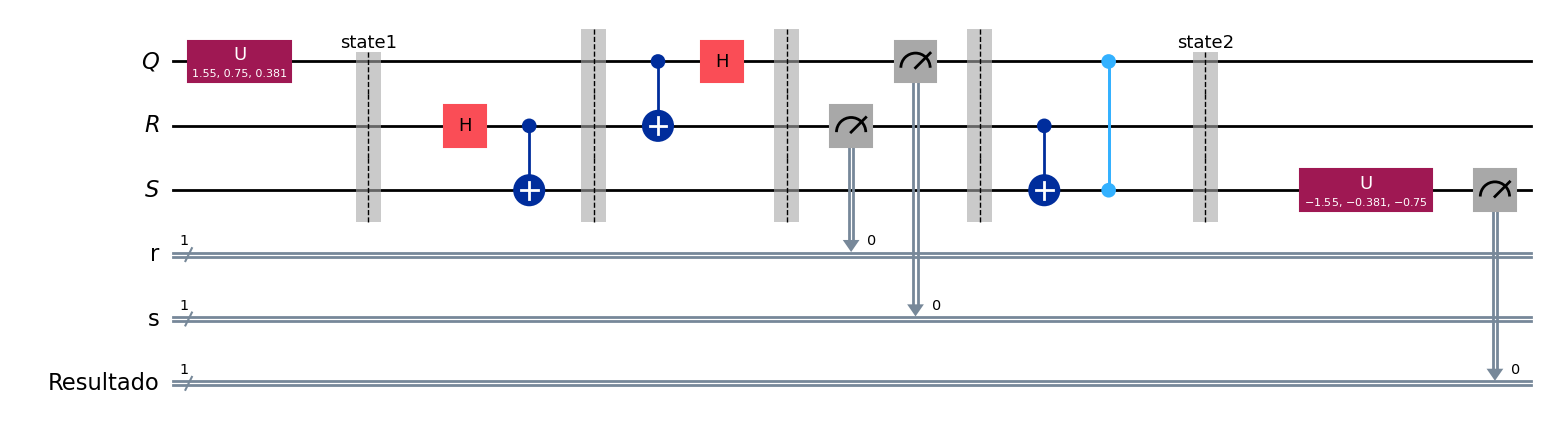

In [7]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

teleport3 = QuantumCircuit(qubitQ, qubitR, qubitS, r, s)

# Aplicamos la puerta aleatoria a Q
teleport3.append(puertaAleatoria, qubitQ)
teleport3.save_statevector("state1") # Guardamos el estado

# Alice prepara un estado entrelazado entre R y S
teleport3.h(qubitR)
teleport3.cx(qubitR, qubitS)
teleport3.barrier()

# Alice realiza una medición de Bell sobre sus qubits Q y R
teleport3.cx(qubitQ, qubitR)
teleport3.h(qubitQ)
teleport3.barrier()

# Realizamos mediciones y enviamos los bits clasicos a Bob por un canal clasico
teleport3.measure(qubitR, r)
teleport3.measure(qubitQ, s)
teleport3.barrier()

# Operaciones del protocolo, empleando estados colapsados (puertas CX y CZ)
teleport3.cx(1,2)
teleport3.cz(0,2)
teleport3.save_statevector("state2") # Guardamos el estado final

# Aplicamos la inversa de la puertaAleatoria y medimos B
teleport3.append(puertaAleatoria.inverse(), qubitS)

# Medimos el qubit de Bob
result = ClassicalRegister(1, "Resultado")
teleport3.add_register(result)
teleport3.measure(qubitS,result) 

# Mostramos el circuito
teleport3.draw('mpl')

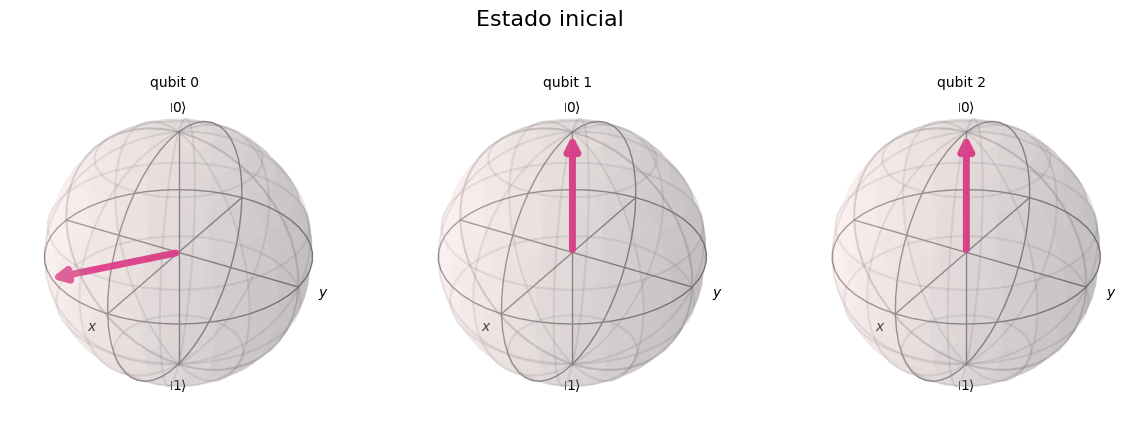

In [25]:
# Realizamos simulacion local
simulator = AerSimulator()
result = simulator.run(transpile(teleport3, simulator)).result()
# Print initial state:
plot_bloch_multivector(result.data(0)['state1'], "Estado inicial")

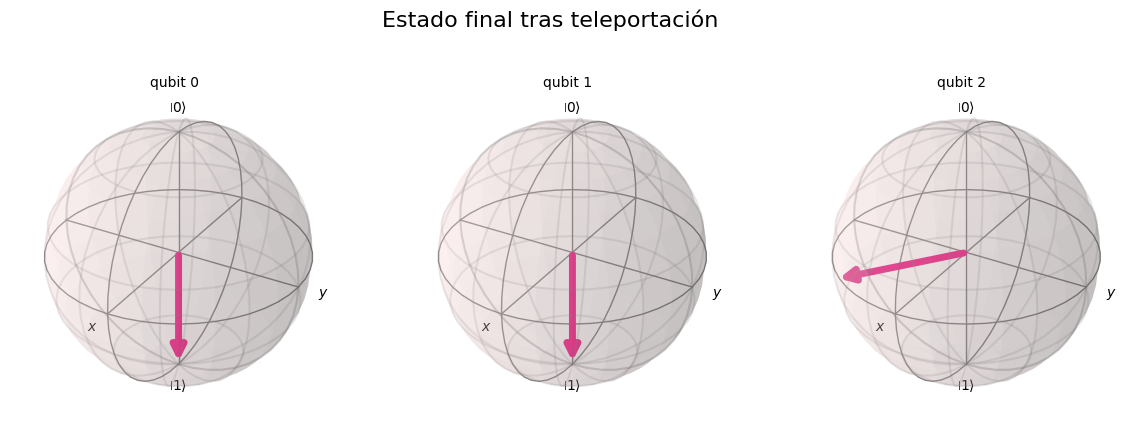

In [26]:
plot_bloch_multivector(result.data(0)['state2'], "Estado final tras teleportación")

En el estado final, tras la teleportación, q0 y q1 han colapsado y en q2 observamos el mismo estado que en q0 en el estado inicial. De esta otra forma, también demostramos que la teleportación cuántica ha sido exitosa.

**Ejercicio 2**. Implementar con Qiskit la codificación superdensa, simulándolo con al menos dos simuladores locales. ¿Cómo compruebas que funciona? Mostrar y comentar resultados.

La codificación superdensa es un protocolo que permite la transmisión de dos bits clásicos utilizando un solo qubit.

In [8]:
# Importamos todo lo necesario
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [9]:
# Especificación de los bits a transmitir (b1 b2)
b1 = "1"
b2 = "0"

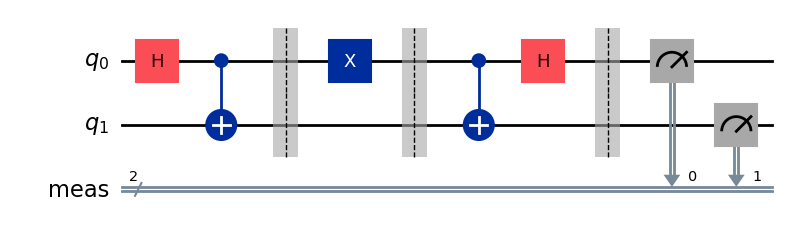

In [10]:
superdense = QuantumCircuit(2)

# Preparamos el qubit para el protocolo
superdense.h(0)
superdense.cx(0, 1)
superdense.barrier()

# Operaciones del protocolo realizadas por Alice
if b2 == "1":
    superdense.z(0)
if b1 == "1":
    superdense.x(0)
superdense.barrier()

# Operaciones realizadas por Bob
superdense.cx(0, 1)
superdense.h(0)
superdense.measure_all()

superdense.draw('mpl')

Ejecutamos utilizando el simulador Aer.

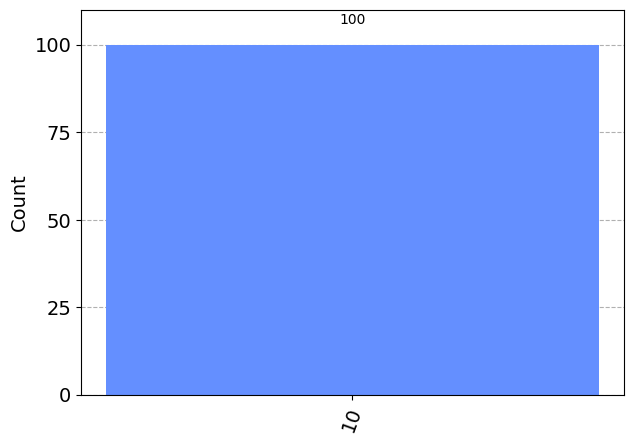

In [32]:
counts = AerSimulator().run(transpile(superdense), shots = 100).result().get_counts()
plot_histogram(counts)

De esta forma, comprobamos que funciona. Para comprobar el resto de codificaciones, bastaría con ejecutar de nuevo las celdas anteriores variando los valores de b1 y b2. Sin embargo, por demostrar que todos funcionan en una sola ejecución, podemos emplear un qubit adicional para generar números aleatorios para b1 y b2, aplicar el protocolo y plotear los resultados.

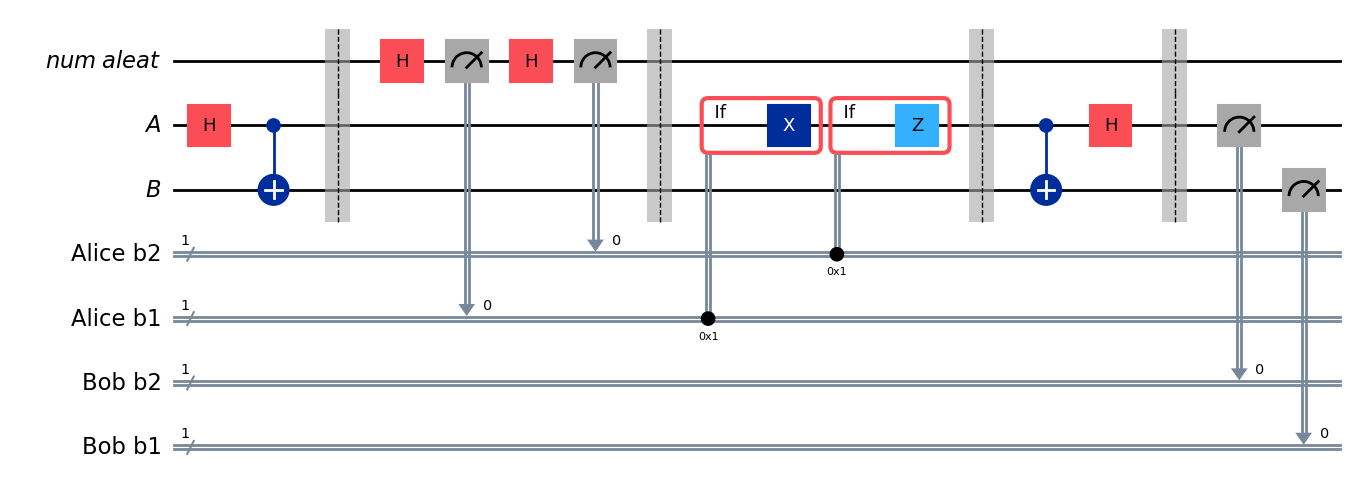

In [22]:
qubitAleat = QuantumRegister(1, "num aleat")
qubitA = QuantumRegister(1, "A")
qubitB = QuantumRegister(1, "B")

Alice_b1 = ClassicalRegister(1, "Alice b1")
Alice_b2 = ClassicalRegister(1, "Alice b2")

new_superdense = QuantumCircuit(qubitAleat, qubitA, qubitB, Alice_b2, Alice_b1)

# Preparamos el qubit A para el protocolo 
new_superdense.h(qubitA)
new_superdense.cx(qubitA, qubitB)
new_superdense.barrier()

# Empleamos el qubit generador de numeros aleatorios para generar b1 y b2
new_superdense.h(qubitAleat)
new_superdense.measure(qubitAleat, Alice_b1)
new_superdense.h(qubitAleat)
new_superdense.measure(qubitAleat, Alice_b2)
new_superdense.barrier()

# Aplicamos operaciones del protocolo, según los bits
with new_superdense.if_test((Alice_b1, 1), label="X"):
    new_superdense.x(qubitA)
with new_superdense.if_test((Alice_b2, 1), label="Z"):
    new_superdense.z(qubitA)
new_superdense.barrier()

# Acciones de Bob
new_superdense.cx(qubitA, qubitB)
new_superdense.h(qubitA)
new_superdense.barrier()

Bob_b1 = ClassicalRegister(1, "Bob b1")
Bob_b2 = ClassicalRegister(1, "Bob b2")
new_superdense.add_register(Bob_b2)
new_superdense.add_register(Bob_b1)
new_superdense.measure(qubitA, Bob_b2)
new_superdense.measure(qubitB, Bob_b1)

new_superdense.draw('mpl')

Ejecutando sobre el simulador Aer, que sí permite circuitos dinámicos, los resultados muestran que los bits clásicos de Alice y Bob siempre coinciden, verificando el correcto funcionamiento del protocolo.

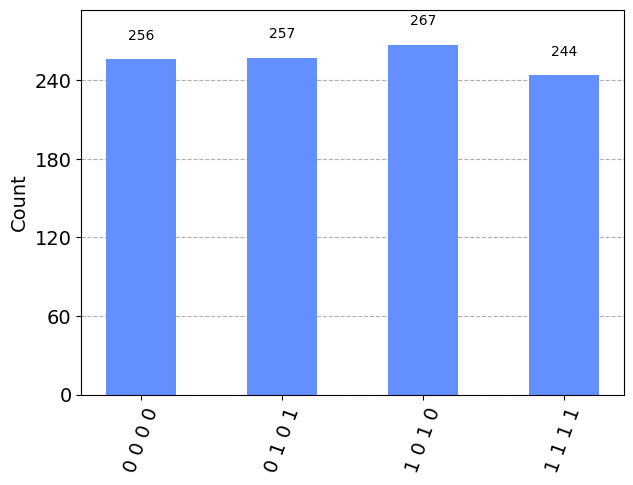

In [23]:
plot_histogram(AerSimulator().run(new_superdense).result().get_counts())

De nuevo, al igual que en el ejercicio anterior se plantea el problema de la simulación de circuitos dinámicos en simuladores que no lo soportan. Podemos aplicar el mismo truco: tras la medición de un qubit su estado colapsa, por lo que podemos colapsar el qubit generador de números aleatorios, tomar su valor, aplicar Hadamard al qubit generador, volver a medir y tomar su segundo valor, utilizando las puertas CZ y CX.

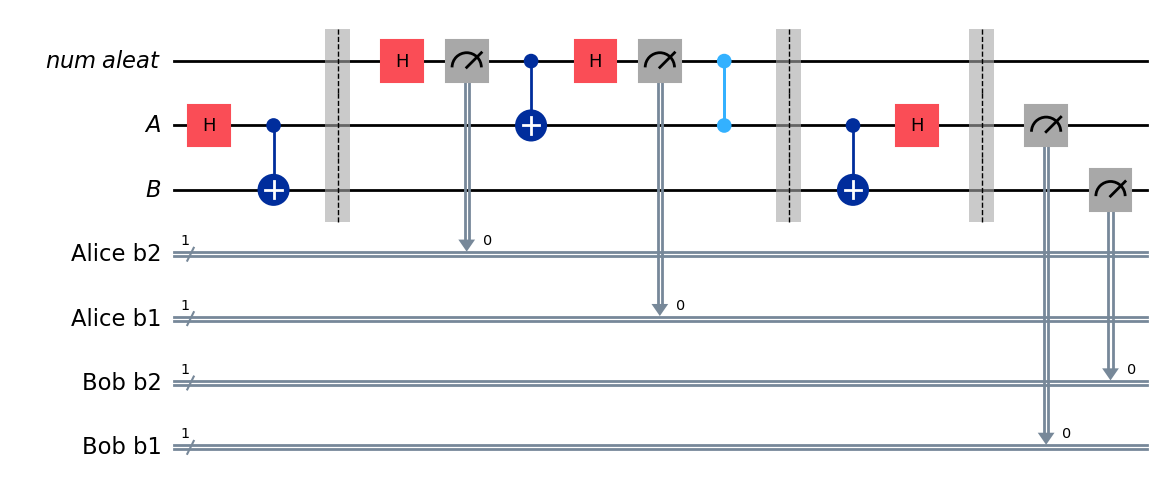

In [26]:
superdense2 = QuantumCircuit(qubitAleat, qubitA, qubitB, Alice_b2, Alice_b1)

# Preparamos el qubit A para el protocolo 
superdense2.h(qubitA)
superdense2.cx(qubitA, qubitB)
superdense2.barrier()

# Empleamos el qubit generador de numeros aleatorios para generar b1 y b2
superdense2.h(qubitAleat)
superdense2.measure(qubitAleat, Alice_b2)
# Tomamos b1
superdense2.cx(qubitAleat,qubitA)
# Repetimos para el segundo bit
superdense2.h(qubitAleat)
superdense2.measure(qubitAleat, Alice_b1)
# Tomamos b2
superdense2.cz(qubitAleat,qubitA)
superdense2.barrier()

# Acciones de Bob
superdense2.cx(qubitA, qubitB)
superdense2.h(qubitA)
superdense2.barrier()

superdense2.add_register(Bob_b2)
superdense2.add_register(Bob_b1)
superdense2.measure(qubitA, Bob_b1)
superdense2.measure(qubitB, Bob_b2)

superdense2.draw('mpl')

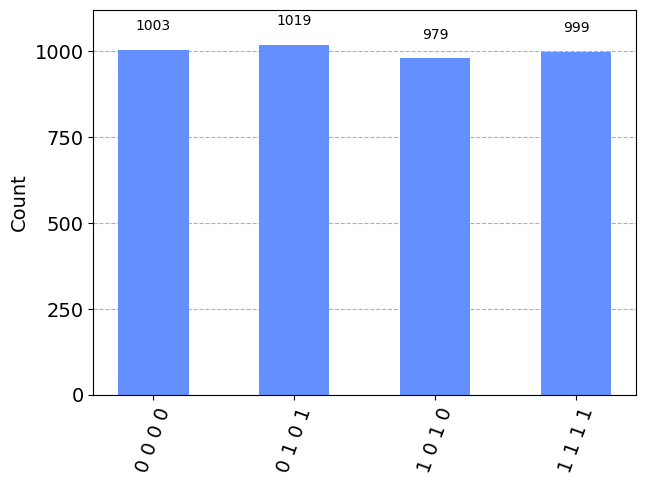

In [27]:
plot_histogram(service.get_backend('ibmq_qasm_simulator').run(transpile(superdense2)).result().get_counts())

Como los bits de Alice y Bob coinciden, queda demostrado el correcto funcionamiento del protocolo.

**Ejercicio 3**. Repetir los ejercicios 1 y 2 codificándolo con Qiskit, realizando ejecuciones en backends reales de IBM.

Para este ejercicio, realizaremos 6 ejecuciones para cada protocolo: 3 para la versión de cada protocolo con circuito dinámico y 3 para la versión de circuito estático empleando un qubit adicional.

Realizamos ejecuciones en backends reales de la **teleportación cuántica** con **circuito dinámico**:

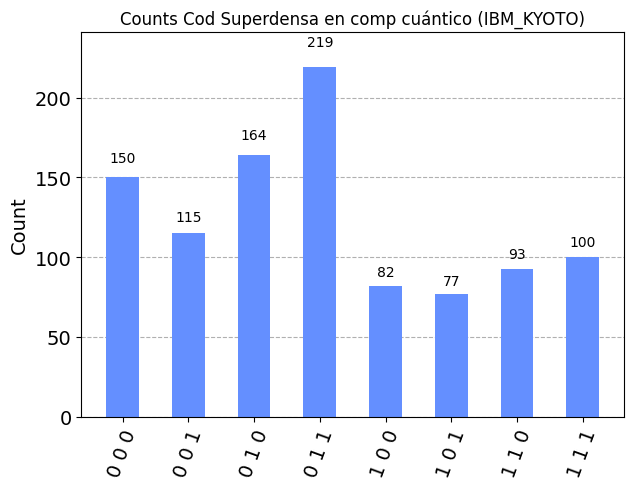

In [55]:
backend = service.get_backend("ibm_kyoto")
counts = backend.run(transpile(newTeleport, backend), shots = 1000).result().get_counts()
plot_histogram(counts, title="Counts Teleportacion Cuantica en comp cuántico (IBM_KYOTO)")

**Nota.** Aunque en el título de la entrada anterior aparezca "Counts Cod Superdensa en com cuántico", se corresponde con la ejecución de newTeleport. Es un resultado de teleportación cuántica.

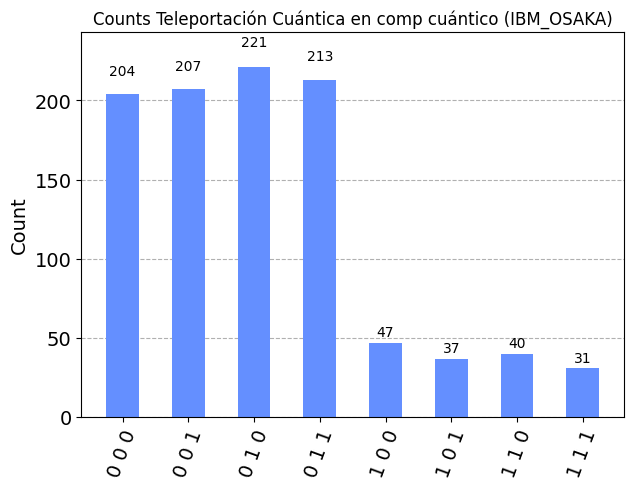

In [40]:
#backend = service.get_backend("ibm_osaka")
#counts = backend.run(transpile(newTeleport, backend), shots = 1000).result().get_counts()
#plot_histogram(counts, title="Counts Teleportacion Cuantica en comp cuántico (IBM_OSAKA)")
job = service.job('cqr0j60417q0008yw7x0')
plot_histogram(job.result().get_counts(), title="Counts Teleportación Cuántica en comp cuántico (IBM_OSAKA)")

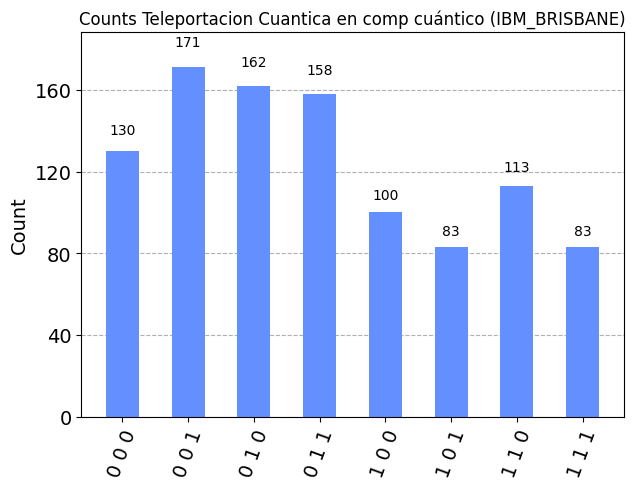

In [41]:
backend = service.get_backend("ibm_brisbane")
counts = backend.run(transpile(newTeleport, backend), shots = 1000).result().get_counts()
plot_histogram(counts, title="Counts Teleportacion Cuantica en comp cuántico (IBM_BRISBANE)")

Realizamos ejecuciones en backends reales de la **teleportación cuántica** con **circuito estático y qubit adicional**:

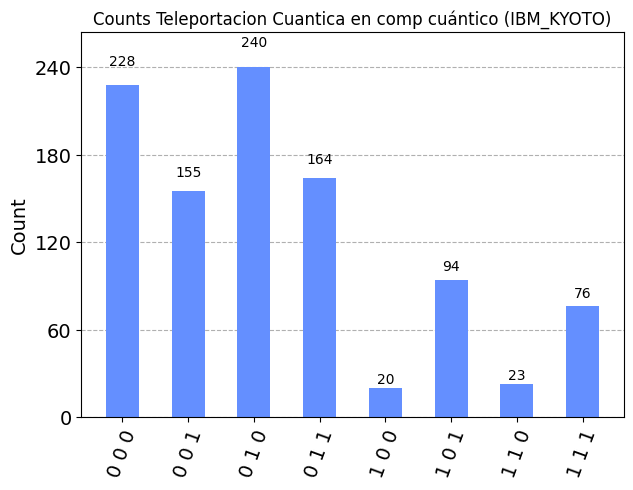

In [33]:
backend = service.get_backend("ibm_kyoto")
counts = backend.run(transpile(teleport2, backend), shots = 1000).result().get_counts()
plot_histogram(counts, title="Counts Teleportacion Cuantica en comp cuántico (IBM_KYOTO)")

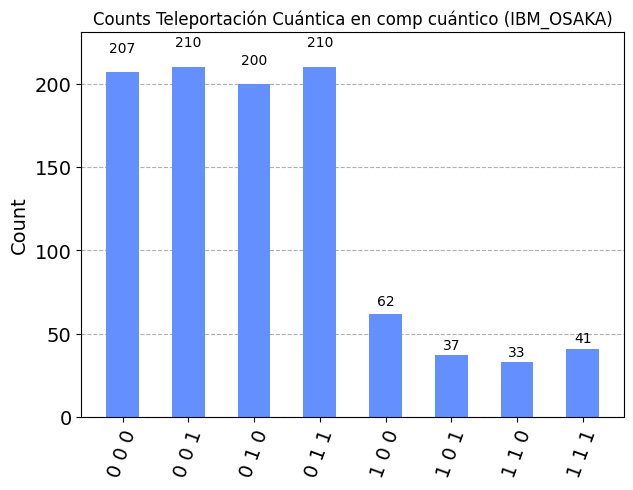

In [38]:
#backend = service.get_backend("ibm_osaka")
#counts = backend.run(transpile(teleport2, backend), shots = 1000).result().get_counts()
#plot_histogram(counts, title="Counts Teleportacion Cuantica en comp cuántico (IBM_OSAKA)")
#########################################
job = service.job('cqqnntfjx32g008562k0')
plot_histogram(job.result().get_counts(), title="Counts Teleportación Cuántica en comp cuántico (IBM_OSAKA)")

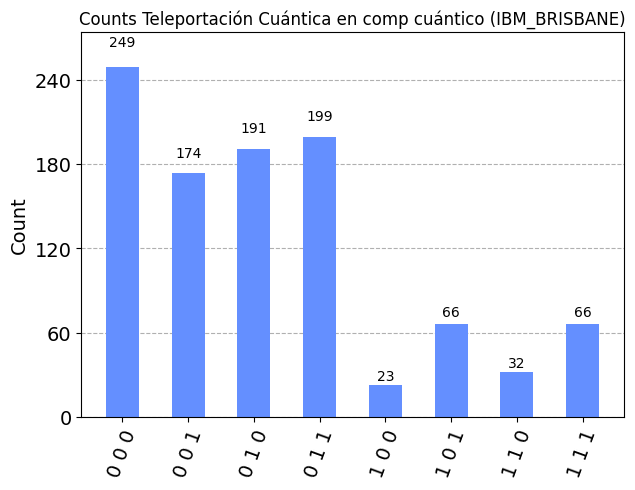

In [36]:
#backend = service.get_backend("ibm_brisbane")
#counts = backend.run(transpile(teleport2, backend), shots = 1000).result().get_counts()
#plot_histogram(counts, title="Counts Teleportacion Cuantica en comp cuántico (IBM_BRISBANE)")
#########################################
job = service.job('cqqj0ybv78p0008j4ad0')
plot_histogram(job.result().get_counts(), title="Counts Teleportación Cuántica en comp cuántico (IBM_BRISBANE)")

Observamos una diferencia notable de resultados en Brisbane, con una tasa de error mucho menor para el circuito estático con qubit adicional. En Kyoto apreciamos también una diferencia significativa, aunque menor que con respecto a Brisbane. Osaka presenta una tasa de error similar en ambas variantes.

Realizamos ejecuciones en backends reales de la **codificación superdensa** en circuitos dinámicos:

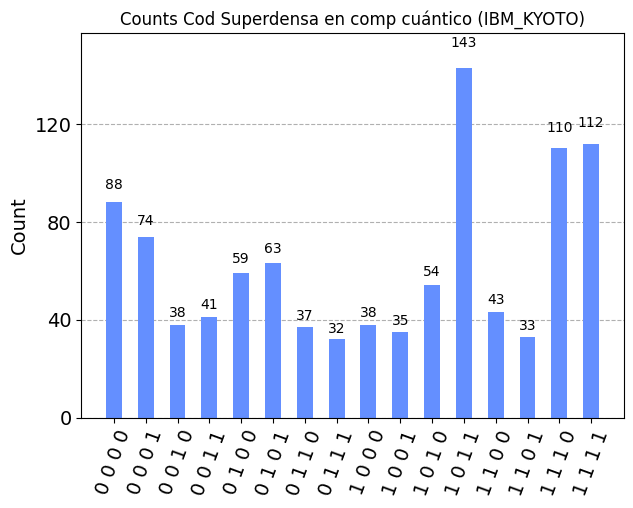

In [28]:
backend = service.get_backend("ibm_kyoto")
counts = backend.run(transpile(new_superdense, backend), shots = 1000).result().get_counts()
plot_histogram(counts, title="Counts Cod Superdensa en comp cuántico (IBM_KYOTO)")

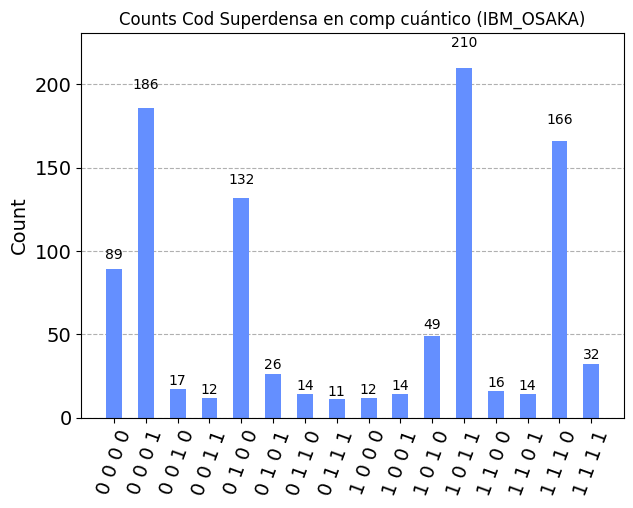

In [44]:
#backend = service.get_backend("ibm_osaka")
#counts = backend.run(transpile(new_superdense, backend), shots = 1000).result().get_counts()
#plot_histogram(counts, title="Counts Cod Superdensa en comp cuántico (IBM_OSAKA)")
job = service.job('cqr2pchv78p0008xhw4g')
plot_histogram(job.result().get_counts(), title="Counts Cod Superdensa en comp cuántico (IBM_OSAKA)")

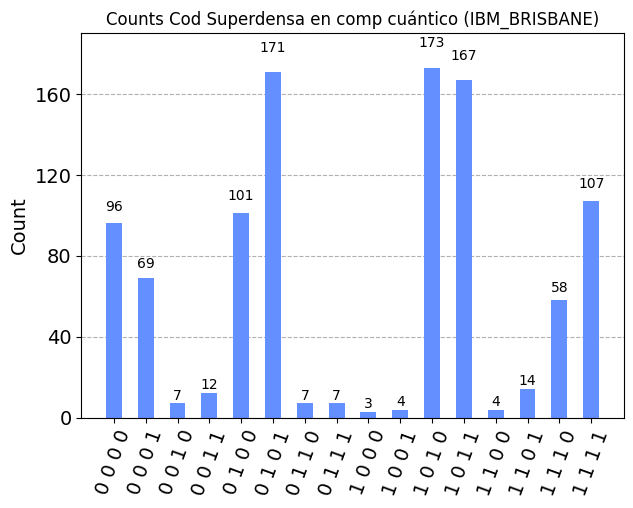

In [17]:
#backend = service.get_backend("ibm_brisbane")
#counts = backend.run(transpile(new_superdense, backend), shots = 1000).result().get_counts()
#plot_histogram(counts, title="Counts Cod Superdensa en comp cuántico (IBM_BRISBANE)")
#########################################
job = service.job('cqp63sqv78p0008mycqg')
plot_histogram(job.result().get_counts(), title="Counts Cod Superdensa en comp cuántico (IBM_BRISBANE)")

**Codificación superdensa** en circuitos estáticos, empleando un qubit adicional para los valores de la codificación:

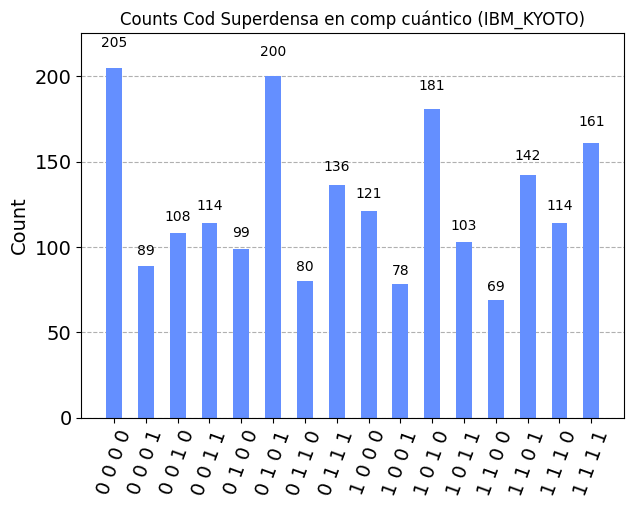

In [29]:
backend = service.get_backend("ibm_kyoto")
counts = backend.run(transpile(superdense2, backend), shots = 2000).result().get_counts()
plot_histogram(counts, title="Counts Cod Superdensa en comp cuántico (IBM_KYOTO)")

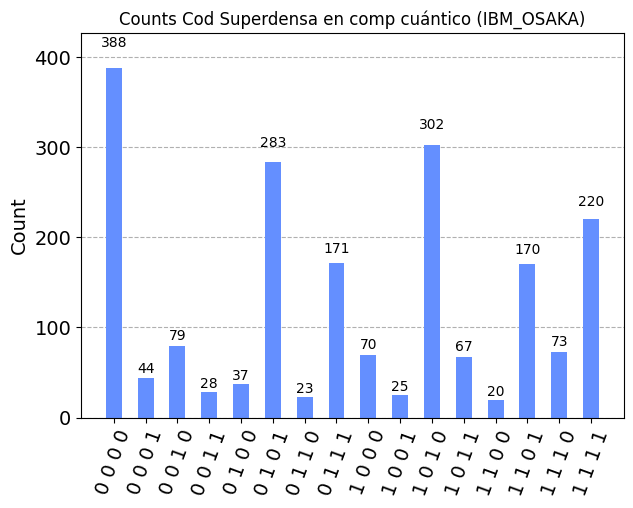

In [45]:
backend = service.get_backend("ibm_osaka")
counts = backend.run(transpile(superdense2, backend), shots = 2000).result().get_counts()
plot_histogram(counts, title="Counts Cod Superdensa en comp cuántico (IBM_OSAKA)")

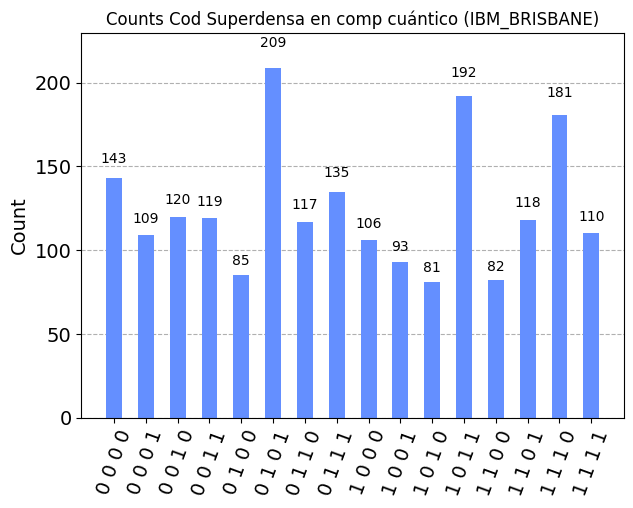

In [42]:
backend = service.get_backend("ibm_brisbane")
counts = backend.run(transpile(superdense2, backend), shots = 2000).result().get_counts()
plot_histogram(counts, title="Counts Cod Superdensa en comp cuántico (IBM_BRISBANE)")

Para empezar, la ejecución de la codificación superdensa sobre el backend Kyoto con circuito dinámico ofrece unos resultados completamente inaceptables: en vista de la gráfica, no hay forma de determinar si quiera cuáles son los valores esperados. Al observar los resultados para el circuito estático, en cambio, observamos unos resultados más aceptables, pues todos los máximos se corresponden con los resultados esperados, aunque la tasa de error siga siendo elevada.

Con respecto a Osaka, los máximos se ubican en valores incorrectos, cercanos a los supuestos valores esperados. Este efecto es extraño, sobre todo teniendo en cuenta que la simulación en Aer, que soporta circuitos dinámicos, sí ofrecía los resultados esperados. Por otra parte, la versión que utiliza circuitos estáticos ofrece resultados mucho más satisfactorios, con los máximos en los valores esperados. La tasa de error es, de hecho, menor que en Tokyo para la misma implementación.

Por último, sorprendentemente la ejecución del backend Brisbane sobre la implementación con circuitos dinámicos ofrece mejores resultados que la ejecución con circuito estático y un qubit adicional. 

Realizando un par de pruebas adicionales sobre backends reales para la codificación superdensa, sin emplear circuitos dinámicos ni qubits adicionales, observamos un comportamiento mucho más eficiente. Brisbane ofrece una tasa de errores menor que Kyoto.

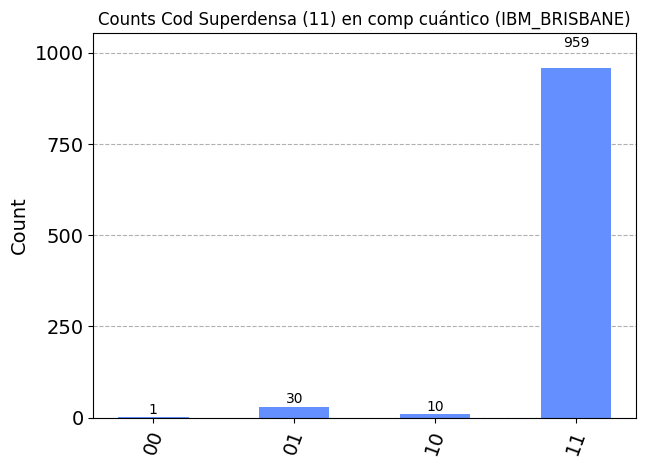

In [63]:
# Ejecucion en IBMQ Brisbane --> Codificacion Superdensa 11

backend = service.get_backend("ibm_brisbane")

q = QuantumRegister(2,'q')
c = ClassicalRegister(2,'c')
circuit = QuantumCircuit(q,c)

circuit.h(q[0])
circuit.cx(q[0],q[1])
circuit.barrier()
circuit.z(q[0]) # Pauli Z
circuit.x(q[0]) # Pauli X
circuit.barrier()
circuit.cx(q[0],q[1])
circuit.h(q[0])
circuit.measure(q,c)
counts = backend.run(transpile(circuit, backend), shots = 1000).result().get_counts()
plot_histogram(counts,
               title="Counts Cod Superdensa (11) en comp cuántico (IBM_BRISBANE)")

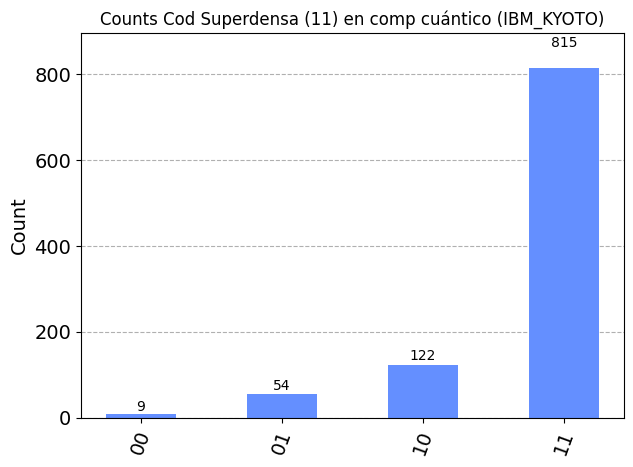

In [64]:
# Ejecucion en IBMQ Kyoto --> Codificacion Superdensa 11

backend = service.get_backend("ibm_kyoto")

q = QuantumRegister(2,'q')
c = ClassicalRegister(2,'c')
circuit = QuantumCircuit(q,c)

circuit.h(q[0])
circuit.cx(q[0],q[1])
circuit.barrier()
circuit.z(q[0]) # Pauli Z
circuit.x(q[0]) # Pauli X
circuit.barrier()
circuit.cx(q[0],q[1])
circuit.h(q[0])
circuit.measure(q,c)
counts = backend.run(transpile(circuit, backend), shots = 1000).result().get_counts()
plot_histogram(counts,
               title="Counts Cod Superdensa (11) en comp cuántico (IBM_KYOTO)")

De los resultados obtenidos concluimos que la tasa de erroes es quizás mayor a la deseada en ejecuciones reales y que la implementación de circuitos dinámicos ofrece resultados dispares, por lo que de ahora en adelante se priorizarán las pruebas que eviten emplear este tipo de circuitos.

**Ejercicio 4**. Repetir los ejercicios 1 y 2 codificándolo con Qiskit, realizando ejecuciones en backends reales de IonQ y/o Quantinuum.

In [2]:
from azure.quantum import Workspace
from azure.identity import DefaultAzureCredential
from azure.quantum.qiskit import AzureQuantumProvider

credential = DefaultAzureCredential(exclude_interactive_browser_credential=False,
                                    interactive_browser_tenant_id="")

# Copy the settings for your workspace below
workspace = Workspace(
    resource_id = "", 
    location = "uksouth",
    credential=credential
)

from qiskit import QuantumCircuit
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

# Listado de targets disponibles
provider = AzureQuantumProvider(workspace)

provider.backends()

[<IonQSimulatorQirBackend('ionq.simulator')>,
 <IonQSimulatorBackend('ionq.simulator')>,
 <IonQSimulatorNativeBackend('ionq.simulator')>,
 <IonQQPUQirBackend('ionq.qpu')>,
 <IonQQPUBackend('ionq.qpu')>,
 <IonQQPUNativeBackend('ionq.qpu')>,
 <IonQAriaQirBackend('ionq.qpu.aria-1')>,
 <IonQAriaBackend('ionq.qpu.aria-1')>,
 <IonQAriaNativeBackend('ionq.qpu.aria-1')>,
 <IonQAriaQirBackend('ionq.qpu.aria-2')>,
 <IonQAriaBackend('ionq.qpu.aria-2')>,
 <IonQAriaNativeBackend('ionq.qpu.aria-2')>,
 <QuantinuumSyntaxCheckerQirBackend('quantinuum.sim.h1-1sc')>,
 <QuantinuumSyntaxCheckerBackend('quantinuum.sim.h1-1sc')>,
 <QuantinuumSyntaxCheckerQirBackend('quantinuum.sim.h1-2sc')>,
 <QuantinuumSyntaxCheckerBackend('quantinuum.sim.h1-2sc')>,
 <QuantinuumEmulatorQirBackend('quantinuum.sim.h1-1e')>,
 <QuantinuumEmulatorBackend('quantinuum.sim.h1-1e')>,
 <QuantinuumEmulatorQirBackend('quantinuum.sim.h1-2e')>,
 <QuantinuumEmulatorBackend('quantinuum.sim.h1-2e')>,
 <QuantinuumQPUQirBackend('quantinuum.qp

Desgraciadamente, se agotaron todos los créditos para ejecutar en backends reales de Azure (Microsoft).